# Image Processing: Histogram of Oriented Gradients (HOG) with MNIST Dataset

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
from skimage.feature import hog
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random

In [2]:
def apply_hog(img, o = 9, ppc = (8, 8), cpb = (2, 2)):
    # apply HOG to image
    features = hog(
        img,
        orientations = o,
        pixels_per_cell = ppc,
        cells_per_block = cpb,
    )

    return features

In [3]:
# set GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The `MNIST` class loads in the data.
- Train set size: 60000
- Test set size: 10000

All images have size $28\times 28$ pixels.

In [4]:
# load datasets and transform to tensors
mnist_train = MNIST("./data/", download = True, transform = transforms.ToTensor())
mnist_test = MNIST("./data/", train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



**NOTE:** The `ToTensor()` method transform a `PIL` image into a Torch tensor!

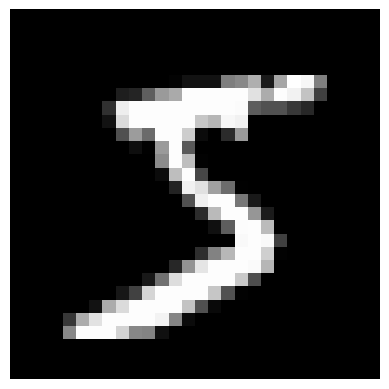

Image Shape: torch.Size([28, 28])
Target: tensor(5)

Train Set (Image): torch.Size([60000, 28, 28])
Train Set (Target): torch.Size([60000])

Test Set (Image): torch.Size([10000, 28, 28])
Test Set (Target): torch.Size([10000])


In [5]:
# sample = first image
sample_image = mnist_train.data[0, :, :]
sample_target = mnist_train.targets[0]

# show image
plt.imshow(sample_image, cmap = "gray")
plt.axis("off")
plt.show()

print("Image Shape:", sample_image.shape)
print("Target:", sample_target)
print()
print("Train Set (Image):", mnist_train.data.shape)
print("Train Set (Target):", mnist_train.targets.shape)
print()
print("Test Set (Image):", mnist_test.data.shape)
print("Test Set (Target):", mnist_test.targets.shape)

In [6]:
targets = mnist_train.targets
print(targets)
print(targets.shape)
print(targets.reshape(1, -1))

tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
tensor([[5, 0, 4,  ..., 5, 6, 8]])


Apply `OneHotEncoder` to the targets. Each label will be expanded to 10 dimensions.
- `reshape(-1, 1)`: changes the dimensions of the target into a $N\times 1$ vector
- `reshape(1, -1)`: changes the dimensions of the target into a $1\times N$ vector (**not what we want**)

In [7]:
# initialize one hot encoder for targets
enc = OneHotEncoder(sparse = False)
enc.fit(targets.reshape(-1, 1))
print(list(enc.get_feature_names_out()))
print(enc.transform([[9]]))

['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7', 'x0_8', 'x0_9']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


**NOTE:** The `OneHotEncoder` needs the input to be reshaped by `reshape(-1, 1)`!

The HOG function with the following parameters outputs a 1D feature array of size 144.
- `orientations = 9`
- `pixels_per_cell = (8, 8)`
- `cells_per_block = (2, 2)`

In [8]:
# apply HOG to sample image
sample_features = apply_hog(sample_image)
print(sample_features.shape)

(144,)


In [9]:
# define linear model
model = nn.Linear(144, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [10]:
# initialize data loader
BATCH_SIZE = 128
train_loader = DataLoader(mnist_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = BATCH_SIZE, shuffle = False)

The model will traverse the entire dataset `num_epochs` times. In each epoch, the model will be trained at `BATCH_SIZE` samples at a time.
1. Transform each batch of labels with `OneHotEncoder` after reshaping (*fitted previously*).
   1. Convert to `torch` tensor.
   2. Convert to `LongTensor` (*categorical target*)
2. Extract HOG features from *each* image from the batch of images.
   1. Convert to `numpy` array.
   2. Convert from `numpy` to `torch` tensor.
   3. Send to GPU device.
3. Forward and backward passes.

In [11]:
counter = 0
for it in range(1):
    for images, labels in train_loader:
        if counter >= 1:
            break
        print("Original:", images.shape, labels.shape)
        labels = torch.from_numpy(enc.transform(labels.reshape(-1, 1))).type(torch.LongTensor).to(device)
        print("Label Transform:", labels.shape)
        features = torch.from_numpy(np.array([ apply_hog(img[0]) for img in images ])).to(device)
        print("Image Transform:", features.shape)

        counter += 1

Original: torch.Size([128, 1, 28, 28]) torch.Size([128])
Label Transform: torch.Size([128, 10])
Image Transform: torch.Size([128, 144])


In [12]:
# train model
losses = []
num_epochs = 8
for it in range(num_epochs):
    for images, labels in train_loader:
        # apply OneHotEncoder to labels (after reshaping)
        labels = enc.transform(labels.reshape(-1, 1))
        labels = torch.from_numpy(labels).to(device)

        # apply HOG to images and convert to tensors
        features = np.array([ apply_hog(img[0]) for img in images ])
        features = torch.from_numpy(features).to(device)
        
        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

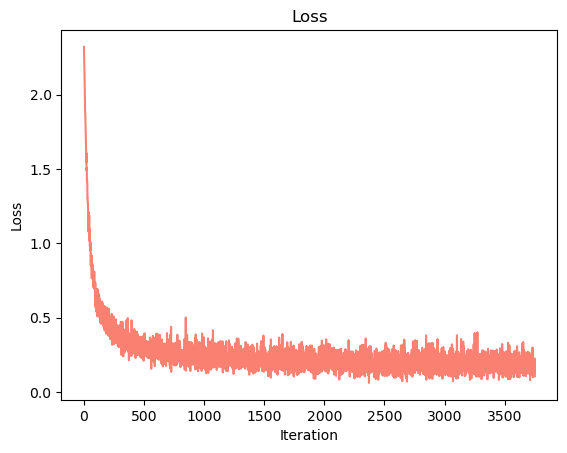

In [ ]:
# plot loss
plt.plot(losses, c = "salmon")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

We make a sample prediction.
- `cpu()`: send it back to CPU
- `detach()`: returns a new Tensor, detached from the current graph
- `numpy()`: convert to numpy

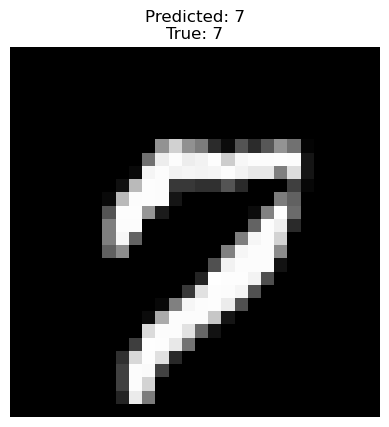

Target: tensor(7)


In [ ]:
# make sample prediction
idx = random.randint(0, len(mnist_test.data))

# select random data point
sample_test = mnist_test.data[idx, :, :]
sample_target = mnist_test.targets[idx]

# apply HOG to sample test image
sample_test_tensor = torch.tensor(apply_hog(sample_test)).to(device).float()
prediction = enc.inverse_transform(model(sample_test_tensor).cpu().detach().numpy().reshape(1, -1))

# plot
plt.imshow(sample_test, cmap = "gray")
plt.axis("off")
plt.title("Predicted: {}\nTrue: {}".format(prediction.item(), sample_target))
plt.show()
print("Target:", sample_target)


In [ ]:
# make predictions
predicted = model(torch.tensor(
    np.array([ apply_hog(img) for img in mnist_test.data ])
).to(device).float())
predicted = enc.inverse_transform(predicted.cpu().detach().numpy())

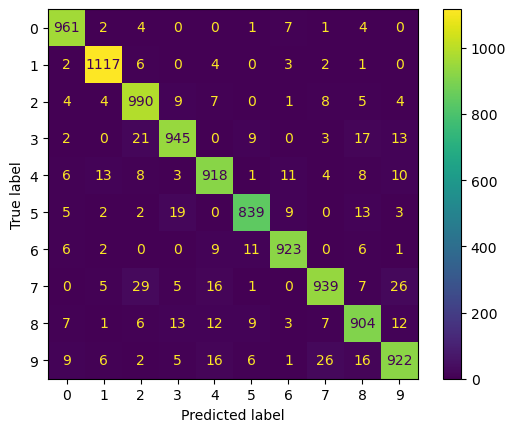

In [ ]:
# construct confusion matrix
matrix = metrics.ConfusionMatrixDisplay.from_predictions(mnist_test.targets.numpy(), predicted)

In [ ]:
accuracy = metrics.accuracy_score(mnist_test.targets.numpy(), predicted)
print("Accuracy:", accuracy)

Accuracy: 0.9458
